In [10]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#import seaborn as sns

from moments_engr import *

In [11]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)
 

In [12]:
print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


 As a preliminary step, we can simulate each user training a gesture classification model using solely their own dataset. We can then execute a pairwise comparison, where we test each user’s model and every other user’s dataset, and report the score. At this point, we can begin a agglomerative clustering procedure, by either clustering the two users with the highest corresponding scores, or by clustering all users that achieved above some minimum cross-subject classification accuracy. Then, we can repeat this procedure on the newly formed clusters, this time training a single model over all the data in the given cluster. By repeating this process until only one model remains, we can generate a dendrogram showing which users are best clustered in order to train cluster-level models. One issue with this approach is that as the clusters grow, the training sets will grow in tandem. To a limited extent, this can be offset by limiting all dataset sizes to the size of single user’s dataset and having the cluster model train on a random sample of gestures. An alternative approach would be to enforce all users into clusters of the same size each round, so that all clusters have the same dataset size, although this would artificially create many clusters. However, we also expect to have the opposite problem, as in myprevious works I have shown that cross-subject models typically perform poorly in general for these types of tasks, e.g. that training over multiple users will likely only grant modest improvements in performance, if any (especially if fixing the training dataset size). The goal of this procedure is to yield clusters for which the internal cluster model performs better than any of the intra-subject models within the cluster. Even if the internal cluster model does not outperform all intra-subject models, as long as it reduces the calibration / number of samples required from a novel user, this is still a success.

In [96]:
# STEP 1: Train a classification model on every single individual user

userdef_df = df1.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [44]:
my_clusters_lst = userdef_df['Cluster_ID'].unique()

#clus_logreg_model_lst = []
clus_svc_model_lst = []
clus_rf_model_lst = []
clus_gbc_model_lst = []
clus_knn_model_lst = []

for clus_idx, clus in enumerate(my_clusters_lst):
    print(f"Cluster {clus_idx} of {len(my_clusters_lst)}")
    #for pid in clus:  # Eg if clus contains multiple users (won't at start FWIW)
    if type(clus) is not type([]):
        clus = [clus]
    clus_trainset = userdef_df[userdef_df['Participant'].isin(clus)]
    
    X_train, X_test, y_train, y_test = train_test_split(np.array(clus_trainset['feature']), np.array(clus_trainset['Gesture_Encoded']), test_size=0.3, random_state=42, stratify=np.array(clus_trainset['Gesture_Encoded']))
    # Dont think Im using X_test or y_test above... I could for benchmarking, but I'll just do it in the below loop...
    #X_train_fixed = np.squeeze(np.array([x.flatten() for x in X_train]), axis=-1)
    X_train_fixed = np.array([x.flatten() for x in X_train])
    X_train = X_train_fixed
    
    # Was reaching max iter without converging
    # Logistic Regression
    #log_reg = LogisticRegression(random_state=42)
    #log_reg.fit(X_train, y_train)
    #y_pred = log_reg.predict(X_test)
    #print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # Support Vector Machine
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_train)
    #y_pred = svm.predict(X_test)
    #print(f"SVM Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    #y_pred = rf.predict(X_test)
    #print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # XGBoost
    #xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    #xgb.fit(X_train, y_train)
    #y_pred = xgb.predict(X_test)
    #print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    # Gradient Boosting Classifier
    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train, y_train)
    #y_pred = gbc.predict(X_test)
    #print(f"Gradient Boosting Classifier Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # k-NN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    #y_pred = knn.predict(X_test)
    #print(f"k-NN Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    
    # Log all models
    #clus_logreg_model_lst.append(log_reg)
    clus_svc_model_lst.append(svm)
    clus_rf_model_lst.append(rf)
    clus_gbc_model_lst.append(gbc)
    clus_knn_model_lst.append(knn)


Cluster 0 of 32
Cluster 1 of 32
Cluster 2 of 32
Cluster 3 of 32
Cluster 4 of 32
Cluster 5 of 32
Cluster 6 of 32
Cluster 7 of 32
Cluster 8 of 32
Cluster 9 of 32
Cluster 10 of 32
Cluster 11 of 32
Cluster 12 of 32
Cluster 13 of 32
Cluster 14 of 32
Cluster 15 of 32
Cluster 16 of 32
Cluster 17 of 32
Cluster 18 of 32
Cluster 19 of 32
Cluster 20 of 32
Cluster 21 of 32
Cluster 22 of 32
Cluster 23 of 32
Cluster 24 of 32
Cluster 25 of 32
Cluster 26 of 32
Cluster 27 of 32
Cluster 28 of 32
Cluster 29 of 32
Cluster 30 of 32
Cluster 31 of 32


In [49]:
# STEP 2: Test each classification model on every other individual user

# THIS NEEDS TO BE REMADE AT EVERY LEVEL! --> each level of the dendrogram will be one smaller than the last
#logregr_clus_sym_matrix = np.zeros((len(my_clusters_lst), len(my_clusters_lst)))
svc_clus_sym_matrix = np.zeros((len(my_clusters_lst), len(my_clusters_lst)))
rf_clus_sym_matrix = np.zeros((len(my_clusters_lst), len(my_clusters_lst)))
gbc_clus_sym_matrix = np.zeros((len(my_clusters_lst), len(my_clusters_lst)))
knn_clus_sym_matrix = np.zeros((len(my_clusters_lst), len(my_clusters_lst)))

for clus_idx, clus in enumerate(my_clusters_lst):
    print(f"Cluster {clus_idx} of {len(my_clusters_lst)}")
    
    # logreg_model = clus_logreg_model_lst[clus_idx]
    svc = clus_svc_model_lst[clus_idx]
    rf = clus_rf_model_lst[clus_idx]
    gbc = clus_gbc_model_lst[clus_idx]
    knn = clus_knn_model_lst[clus_idx]
    
    for clus_idx2, clus2 in enumerate(my_clusters_lst):
        if type(clus2) is not type([]):
            clus2 = [clus2]
        #for pid in clus:  # Eg if clus contains multiple users (won't at level 1 FWIW)
        ## Maybe I don't need to do this... if clus2 is already a list then its fine I think?
        ## Unless models need to be tested on datasets the same num samples as their training set... things will get sticky...
        clus_trainset = userdef_df[userdef_df['Participant'].isin(clus2)]
        _, X_test, _, y_test = train_test_split(np.array(clus_trainset['feature']), np.array(clus_trainset['Gesture_Encoded']), test_size=0.3, random_state=42, stratify=np.array(clus_trainset['Gesture_Encoded']))
        X_test_fixed = np.array([x.flatten() for x in X_test])
        X_test = X_test_fixed

        #logregr_clus_sym_matrix[clus_idx, clus_idx2] =  accuracy_score(y_test, logreg.predict(X_test))
        svc_clus_sym_matrix[clus_idx, clus_idx2] =  accuracy_score(y_test, svc.predict(X_test))
        rf_clus_sym_matrix[clus_idx, clus_idx2] =  accuracy_score(y_test, rf.predict(X_test))
        gbc_clus_sym_matrix[clus_idx, clus_idx2] =  accuracy_score(y_test, gbc.predict(X_test))
        knn_clus_sym_matrix[clus_idx, clus_idx2] =  accuracy_score(y_test, knn.predict(X_test))

Cluster 0 of 32
Cluster 1 of 32
Cluster 2 of 32
Cluster 3 of 32
Cluster 4 of 32
Cluster 5 of 32
Cluster 6 of 32
Cluster 7 of 32
Cluster 8 of 32
Cluster 9 of 32
Cluster 10 of 32
Cluster 11 of 32
Cluster 12 of 32
Cluster 13 of 32
Cluster 14 of 32
Cluster 15 of 32
Cluster 16 of 32
Cluster 17 of 32
Cluster 18 of 32
Cluster 19 of 32
Cluster 20 of 32
Cluster 21 of 32
Cluster 22 of 32
Cluster 23 of 32
Cluster 24 of 32
Cluster 25 of 32
Cluster 26 of 32
Cluster 27 of 32
Cluster 28 of 32
Cluster 29 of 32
Cluster 30 of 32
Cluster 31 of 32


In [ ]:
# STEP 3: Combine the datasets of the two closest users (best pairwise performance --> is it two-way??)


In [82]:
def visual_test_acc_analysis(test_acc_matrix, plot_heatmaps=True, heatmap_mask_min_val=0.2, print_top_n=True, n=5):

    if plot_heatmaps:
        masked_array = np.ma.masked_where(test_acc_matrix < heatmap_mask_min_val, test_acc_matrix)
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
        # Plot the original matrix
        axes[0].imshow(svc_clus_sym_matrix, cmap='viridis', interpolation='nearest')
        cbar1 = fig.colorbar(axes[0].imshow(test_acc_matrix, cmap='viridis', interpolation='nearest'), ax=axes[0])
        cbar1.set_label('Pairwise Test Accuracy')
        # Plot the masked matrix
        im = axes[1].imshow(masked_array, cmap='viridis', interpolation='nearest')
        cbar2 = fig.colorbar(im, ax=axes[1])
        cbar2.set_label('Pairwise Test Accuracy')
        # Adjust layout for clarity
        plt.tight_layout()
        plt.show()

    if print_top_n:
        # Mask the diagonal by setting it to a very low value (or using masking)
        masked_array = test_acc_matrix.copy()
        np.fill_diagonal(masked_array, 0.0)  # Set diagonal values to 0.0
        # Flatten the array and get the indices of the largest 5 values
        flat_indices = np.argpartition(masked_array.flatten(), -5)[-n:]
        top_values_indices = flat_indices[np.argsort(masked_array.flatten()[flat_indices])[::-1]]
        # Convert flat indices back to 2D indices
        row_col_indices = np.unravel_index(top_values_indices, masked_array.shape)
        top_values = svc_clus_sym_matrix[row_col_indices]
        # Print the results
        print(f"Top {n} values (excluding diagonal):")
        for value, (row, col) in zip(top_values, zip(*row_col_indices)):
            print(f"Value: {value:.4f} at position ({row}, {col})")
            

def extract_top_n_highest_pairs(test_acc_matrix, n=1, print_top_n=False):
    # Mask the diagonal by setting it to a very low value (or using masking)
    masked_array = test_acc_matrix.copy()
    np.fill_diagonal(masked_array, 0.0)  # Set diagonal values to 0.0
    # Flatten the array and get the indices of the largest 5 values
    flat_indices = np.argpartition(masked_array.flatten(), -5)[-n:]
    top_values_indices = flat_indices[np.argsort(masked_array.flatten()[flat_indices])[::-1]]
    # Convert flat indices back to 2D indices
    row_col_indices = np.unravel_index(top_values_indices, masked_array.shape)
    top_values = svc_clus_sym_matrix[row_col_indices]
    if print_top_n:
        print(f"Top {n} values (excluding diagonal):")
        for value, (row, col) in zip(top_values, zip(*row_col_indices)):
            print(f"Value: {value:.4f} at position ({row}, {col})")
            
    return top_values, row_col_indices

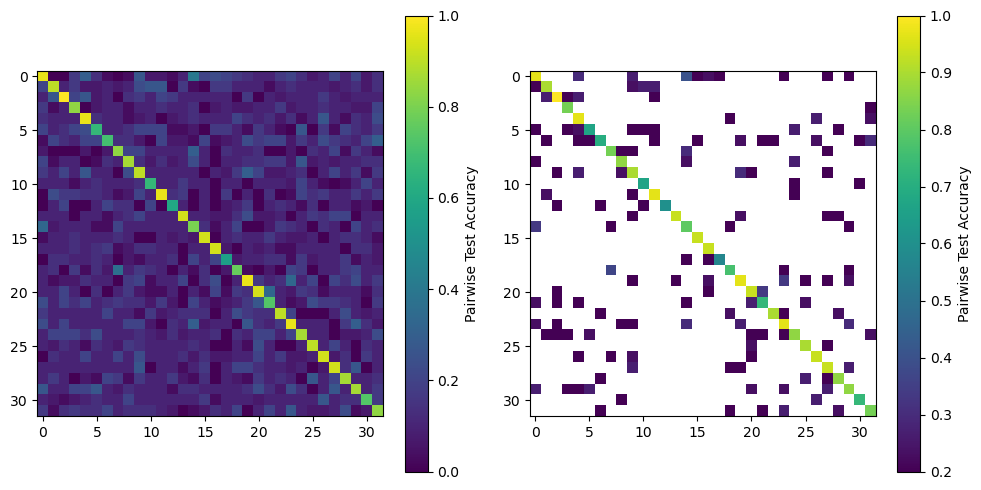

Top 5 values (excluding diagonal):
Value: 0.4000 at position (0, 14)
Value: 0.3667 at position (18, 7)
Value: 0.3333 at position (14, 0)
Value: 0.3333 at position (20, 21)
Value: 0.3333 at position (19, 23)


In [75]:
visual_test_acc_analysis(svc_clus_sym_matrix)

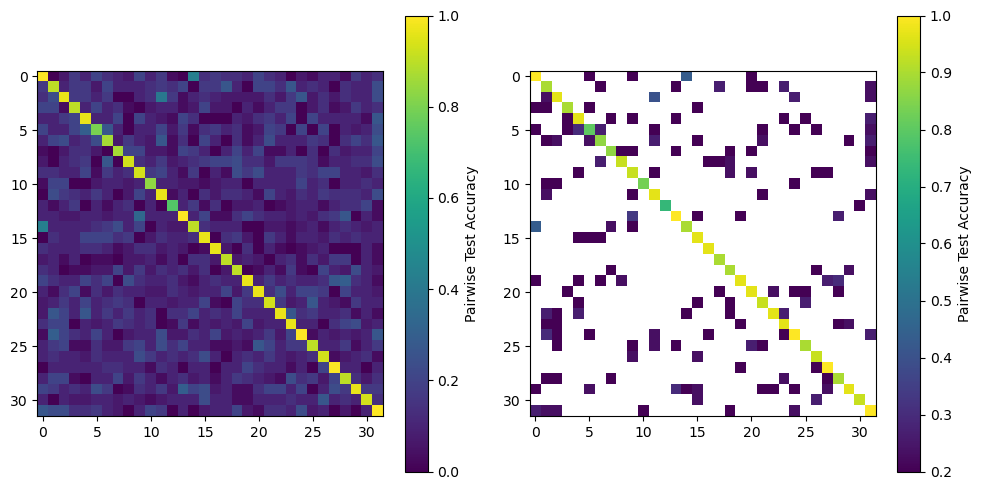

Top 5 values (excluding diagonal):
Value: 0.3333 at position (14, 0)
Value: 0.4000 at position (0, 14)
Value: 0.2000 at position (2, 11)
Value: 0.2000 at position (13, 9)
Value: 0.1333 at position (19, 28)


In [77]:
visual_test_acc_analysis(rf_clus_sym_matrix)

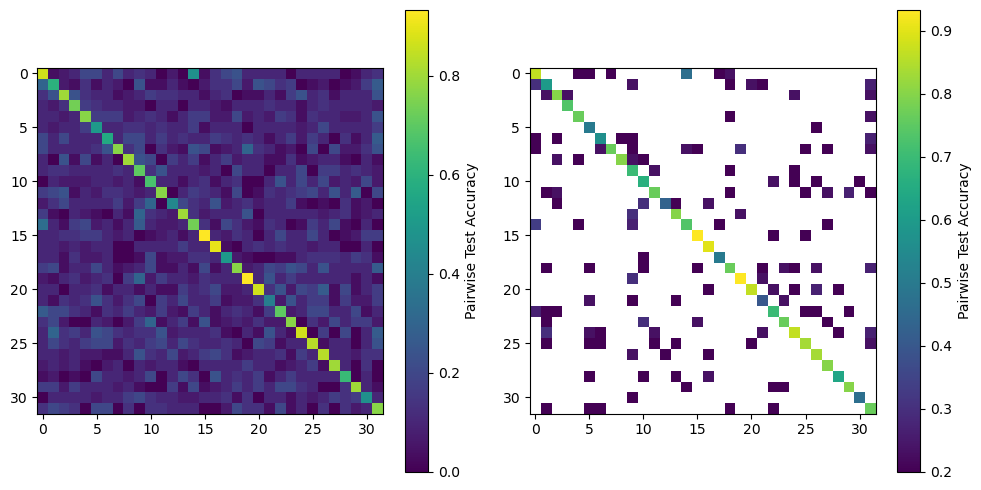

Top 5 values (excluding diagonal):
Value: 0.4000 at position (0, 14)
Value: 0.3333 at position (14, 0)
Value: 0.2000 at position (12, 10)
Value: 0.0667 at position (23, 10)
Value: 0.2000 at position (19, 9)


In [78]:
visual_test_acc_analysis(gbc_clus_sym_matrix)

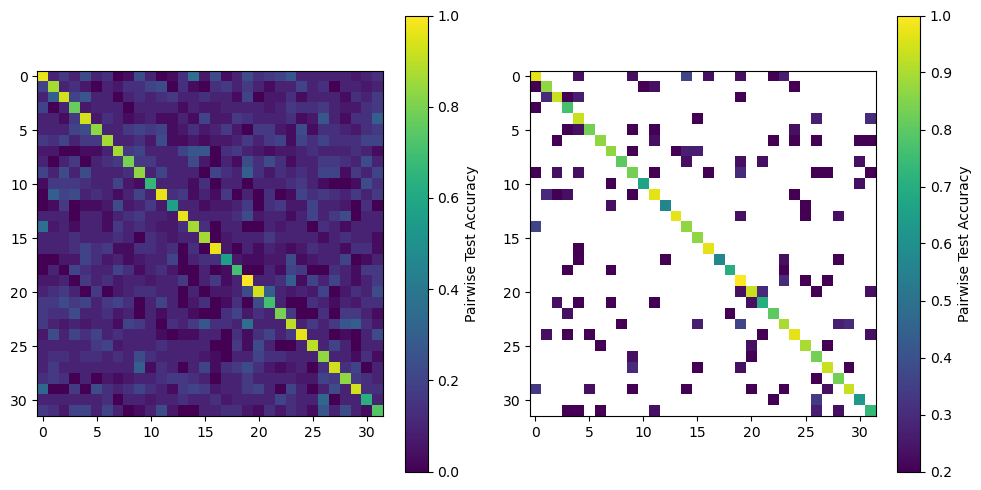

Top 5 values (excluding diagonal):
Value: 0.4000 at position (0, 14)
Value: 0.3333 at position (14, 0)
Value: 0.2667 at position (23, 19)
Value: 0.2667 at position (29, 0)
Value: 0.2667 at position (30, 26)


In [79]:
visual_test_acc_analysis(knn_clus_sym_matrix)

In [64]:
#fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid
#for ax, arr in zip(axes.flat, arrays):
#    sns.heatmap(svc_clus_sym_matrix, ax=ax, cmap='viridis', cbar=False)
#    ax.set_title("Array Heatmap")
#plt.tight_layout()
#plt.show()

In [107]:
svc_top_values, svc_row_col_indices = extract_top_n_highest_pairs(svc_clus_sym_matrix)
rf_top_values, rf_row_col_indices = extract_top_n_highest_pairs(rf_clus_sym_matrix)
gbc_top_values, gbc_row_col_indices = extract_top_n_highest_pairs(gbc_clus_sym_matrix)
knn_top_values, knn_row_col_indices = extract_top_n_highest_pairs(knn_clus_sym_matrix)

print(f"svc_row_col_indices: {svc_row_col_indices[0][0], svc_row_col_indices[1][0]}")
print(f"rf_row_col_indices: {rf_row_col_indices[0][0], rf_row_col_indices[1][0]}")
print(f"gbc_row_col_indices: {gbc_row_col_indices[0][0], gbc_row_col_indices[1][0]}")
print(f"knn_row_col_indices: {knn_row_col_indices[0][0], knn_row_col_indices[1][0]}")

svc_row_col_indices: (14, 0)
rf_row_col_indices: (14, 0)
gbc_row_col_indices: (0, 14)
knn_row_col_indices: (0, 14)


In [103]:
row_to_merge = svc_row_col_indices[0][0]
col_to_merge = svc_row_col_indices[1][0]

userdef_df.loc[userdef_df['Cluster_ID'].isin([row_to_merge, col_to_merge]), 'Cluster_ID'] = max(userdef_df['Cluster_ID'].unique())+1
my_clusters_lst = userdef_df['Cluster_ID'].unique()


In [104]:
my_clusters_lst

array([32,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
# STEP 4: Repeat STEPS 1-3 until only 1 cluster remains

A
 related approach would be doing the above but comparing the model weights more directly, either
 in Euclidean space (e.g., Frobenius norm) or in a latent space (PCA, CCA, autoencoders, etc., just
 trying to find a more structured latent space to compare model weights), and use a similar minimum
 similarity threshold for defining edges in the graph. 

 A final remaining open question is to what extent can this these questions be answered entirely on the basis of body-part used (e.g., clustering based on whether the finger, neck, arm, etc. was used for the gesture). 
 - I would have to watch and categorize the videos for this... I could... I ought to at some point

Additionally, we may be able to leverage mixture of experts related approaches [16, 17, 18], wherein
 each new sample is passed to a gating mechanism which must decide which expert (or in our case,
 cluster model) is best suited for it, and then is run through the corresponding expert model. In our
 scenario, one could imagine having expert models that are ability-based, however that is defined, or
 potentially disability-based or body-part based (e.g., all gestures performed by the fingers will be sent
 to the finger expert model/cluster, etc.). Generally, within a disability diagnosis, there is still a wide
 range of abilities, so explicit disability-based groupings typically are undesirable

# CCA

In [23]:
#convert Gesture_ID to numerical with new Gesture_Encoded column

label_encoder = LabelEncoder()
#result['Gesture_Encoded'] = label_encoder.fit_transform(result['Gesture_ID'])
userdef['Gesture_Encoded'] = label_encoder.fit_transform(userdef['Gesture_ID'])

CCA functions

In [26]:
# Hold out one participant as the expert
def hold_out_expert(data, participant_column):
    participant_ids = data[participant_column].unique()
    expert_user = np.random.choice(participant_ids)  # Randomly select one participant as expert
    data_expert = data[data[participant_column] == expert_user]  # Expert data
    data_remaining = data[data[participant_column] != expert_user]  # Remaining data
    return data_expert, data_remaining

In [27]:
# Train-test split for remaining data
def split_train_test(data, participant_column, test_size=0.2):
    participant_ids = data[participant_column].unique()
    train_ids, test_ids = train_test_split(participant_ids, test_size=test_size, random_state=42)
    
    train_data = data[data[participant_column].isin(train_ids)]
    test_data = data[data[participant_column].isin(test_ids)]
    
    return train_data, test_data

In [28]:
def flatten_features(feature_column):
    # Convert a column of lists of lists into a 2D NumPy array
    return np.array([np.array(item).flatten() for item in feature_column])

#X_expert = flatten_features(expert_data['feature']) #now  a 2D array with 
#X_other = flatten_features(remaining_data['feature'])

#print(X_other)

In [29]:
#inside k_fold function
# Apply CCA btwn expert and train/test
def apply_cca_between_expert_and_others(expert_data, other_data, target_column, n_components=2):
    # Separate features (X) and target (y)
    
    #after flattening to 2D 
    X_expert = flatten_features(expert_data['feature'])
    X_other = flatten_features(other_data['feature'])

    y_expert = expert_data[target_column]
    y_other = other_data[target_column]
    
    # Apply CCA between expert and other participant
    cca = CCA(n_components=n_components)
    #cca.fit(X_expert, y_expert)
    #print(X_expert.shape)
    #print(X_other.shape)
    cca.fit(X_expert, X_other) #might not run bcuz diff shapes
    #need to figure out how to pass in X_others. if not clear from paper, google cca github and try to find expert user and others
    X_other_cca = cca.transform(X_other)
    
    return X_other_cca, y_other#, X_expert, X_other#, X_other, X_expert, y_expert            think we're good to leave this out?

In [30]:
#inside k_fold function
# Run KNN -- used inside cca but can also be used outside
def run_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    return accuracy_score(y_test, y_pred)

In [57]:
# Implement k-fold cross-validation and refer to each of the other functions to run CCA between expert user and training and expert user and testing
def k_fold_cross_validation(data, expert_data, participant_column, target_column, k=5, n_neighbors=5, n_components=2):

    #kf = KFold(n_splits=k, shuffle=True, random_state=42)
    kf = KFold(n_splits=k, shuffle=False)
    accuracies = []
    
    #80/20 train test split. 4 folds in train and 1 in test
    for train_index, test_index in kf.split(data[participant_column].unique()):
        # Split based on participant IDs
        train_ids = data[participant_column].unique()[train_index]
        test_ids = data[participant_column].unique()[test_index]
        
        train_data = data[data[participant_column].isin(train_ids)]
        test_data = data[data[participant_column].isin(test_ids)]
        
        # CCA between expert and training users
        X_train_cca = []
        y_train = []
        for pid in train_ids:
            pid_data = train_data[train_data[participant_column] == pid]
            #print("participant id", pid)
            #print("expert data", expert_data.shape)
            #print("participant data", pid_data.shape)
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_train_cca.append(X_pid_cca)
            y_train.append(y_pid)
        
        # Combine all CCA-transformed training data
        X_train_cca = np.vstack(X_train_cca)
        y_train = np.concatenate(y_train)
        
        # CCA between expert and testing users
        X_test_cca = []
        y_test = []
        for pid in test_ids:
            pid_data = test_data[test_data[participant_column] == pid]
            #change to X_expert, X_other for output     X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_test_cca.append(X_pid_cca)
            y_test.append(y_pid)
        
        # Combine all CCA-transformed testing data
        X_test_cca = np.vstack(X_test_cca)
        y_test = np.concatenate(y_test)
        
        # Run KNN on CCA-transformed feature sets
        accuracy = run_knn(X_train_cca, y_train, X_test_cca, y_test, n_neighbors)
        accuracies.append(accuracy)
    
    return accuracies

In [59]:
#11/11 output with k-fold and averaging for 100 runs

#train_data, test_data = split_train_test(userdef, 'Participant', test_size=0.2)
#In CCA, the number of components must be less than or equal to the number of features in either dataset or the number of samples minus one, whichever is smaller.
#so changed n_components to 1
userdef_rep = {}
for i in range(10):
    expert_data, remaining_data = hold_out_expert(userdef, 'Participant')
    cca_knn_accuracy=k_fold_cross_validation(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_neighbors=5, n_components=2)
    
    #get mean accuracy for each expert_id
    participants = expert_data['Participant'].unique()
    for participant, accuracy in zip(participants, cca_knn_accuracy):
        if participant not in userdef_rep:
            userdef_rep[participant] = []
        userdef_rep[participant].append(accuracy)

# Calculate mean accuracy per participant
mean_accuracies_per_participant = {participant: np.mean(accuracies) for participant, accuracies in userdef_rep.items()}

print("User-Def Mean accuracies per participant:", mean_accuracies_per_participant)

User-Def Mean accuracies per participant: {'P125': 0.36999999999999994, 'P118': 0.35, 'P132': 0.3, 'P105': 0.37, 'P123': 0.4, 'P106': 0.35, 'P111': 0.43}


In [62]:
#baseline PCA
def run_pca_knn(df, n_components=8, n_neighbors=5, test_size=0.2):
    """
    Perform PCA on the 'feature' column and KNN classification on the transformed data.

    Parameters:
        df (DataFrame): Input DataFrame containing 'feature' and 'Gesture_ID' columns.
        n_components (int): Number of PCA components.
        n_neighbors (int): Number of neighbors for KNN.
        test_size (float): Fraction of data to use as the test set.
        random_state (int): Random state for train-test split.

    Returns:
        explained_variance_ratio (array): Explained variance ratio of PCA components.
        accuracy (float): Classification accuracy of KNN on the test set.
    """
    # Convert the 'feature' column from nested lists to a flat list for each entry
    df['feature_flat'] = df['feature'].apply(lambda x: np.ravel(x))

    # Extract features and labels
    X = np.vstack(df['feature_flat'].values)
    y = df['Gesture_ID']

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=test_size)

    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return pca.explained_variance_ratio_, accuracy

#print("standardized")
#explained_variance_ratio, accuracy = run_pca_knn(with_disability, n_components=10, n_neighbors=5)
#print("PCA Explained Variance Ratio:", explained_variance_ratio)
#print("KNN Classification Accuracy:", accuracy)
#print("")
print("user-def") #better at user-def than standardized
explained_variance_ratio, accuracy = run_pca_knn(userdef, n_components=10, n_neighbors=5)
print("PCA Explained Variance Ratio:", explained_variance_ratio)
print("KNN Classification Accuracy:", accuracy)

user-def
PCA Explained Variance Ratio: [0.31883444 0.20147262 0.07229554 0.05143604 0.04524832 0.03273017
 0.02969741 0.02437628 0.02217808 0.01722988]
KNN Classification Accuracy: 0.7578125


In [63]:
#baseline knn
def run_knn_baseline_with_expert(expert_data, remaining_data, target_column, n_neighbors=5, k=5):
    # Flatten the features from both datasets
    X_expert = flatten_features(expert_data['feature'])
    X_remaining = flatten_features(remaining_data['feature'])
    
    # Combine the feature sets and their corresponding targets
    X_combined = np.vstack((X_expert, X_remaining))
    y_expert = expert_data[target_column].values
    y_remaining = remaining_data[target_column].values
    y_combined = np.concatenate((y_expert, y_remaining))

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, test_index in kf.split(X_combined):
        X_train, X_test = X_combined[train_index], X_combined[test_index]
        y_train, y_test = y_combined[train_index], y_combined[test_index]

        # Run KNN on the combined dataset
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return accuracies

#expert_data, remaining_data = hold_out_expert(with_disability, 'Participant')
#baseline_accuracies = run_knn_baseline_with_expert(expert_data, remaining_data, 'Gesture_Encoded')
#print(f'KNN Accuracy: {baseline_accuracies}')
#print("standardized", np.mean(baseline_accuracies))

pers_expert_data, pers_remaining_data = hold_out_expert(userdef, 'Participant')
baseline_accuracies = run_knn_baseline_with_expert(pers_expert_data, pers_remaining_data, 'Gesture_Encoded')
print(f'KNN Accuracy: {baseline_accuracies}')
print("userdef", np.mean(baseline_accuracies))

KNN Accuracy: [0.84375, 0.8234375, 0.81875, 0.775, 0.8109375]
userdef 0.8143749999999998


> Wow that is high accuracy... let me double check things

In [64]:
pers_expert_data

,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,feature_flat
1900,P116,close,1,"[[5.527561206184626], [-8.098585875109096], [-...",0,"[5.527561206184626, -8.098585875109096, -20.00..."
1901,P116,close,10,"[[5.049786408181666], [-6.691335261235313], [-...",0,"[5.049786408181666, -6.691335261235313, -17.23..."
1902,P116,close,2,"[[5.261857313828599], [-7.718602672988598], [-...",0,"[5.261857313828599, -7.718602672988598, -18.78..."
1903,P116,close,3,"[[4.6162905039179085], [-7.227502407333501], [...",0,"[4.6162905039179085, -7.227502407333501, -17.1..."
1904,P116,close,4,"[[6.166422454148102], [-8.883153520789653], [-...",0,"[6.166422454148102, -8.883153520789653, -22.46..."
...,...,...,...,...,...,...
1995,P116,zoom-out,5,"[[5.030362236669886], [-7.115086323656174], [-...",9,"[5.030362236669886, -7.115086323656174, -17.78..."
1996,P116,zoom-out,6,"[[4.509073413170462], [-6.830646649276103], [-...",9,"[4.509073413170462, -6.830646649276103, -16.54..."
1997,P116,zoom-out,7,"[[4.856808873256232], [-7.65270966627144], [-1...",9,"[4.856808873256232, -7.65270966627144, -18.215..."
1998,P116,zoom-out,8,"[[4.591157335933044], [-7.027517336850388], [-...",9,"[4.591157335933044, -7.027517336850388, -16.81..."


In [65]:
pers_remaining_data

,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,feature_flat
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,"[6.079045311063784, -7.551458873254243, -20.17..."
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,"[5.994789910363704, -7.978871468164499, -20.77..."
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,"[6.010193380499154, -7.7063875553339, -20.4852..."
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,"[5.8212078257286874, -7.463908156909893, -19.6..."
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,"[5.974675085061773, -7.945111601415482, -20.66..."
...,...,...,...,...,...,...
3195,P132,zoom-out,5,"[[1.8941044559494014], [-4.088877765699611], [...",9,"[1.8941044559494014, -4.088877765699611, -8.69..."
3196,P132,zoom-out,6,"[[2.3768635651671475], [-4.333723378142736], [...",9,"[2.3768635651671475, -4.333723378142736, -9.65..."
3197,P132,zoom-out,7,"[[2.9880460561483497], [-4.894965494204392], [...",9,"[2.9880460561483497, -4.894965494204392, -11.6..."
3198,P132,zoom-out,8,"[[1.9855560622439246], [-3.4775971454624637], ...",9,"[1.9855560622439246, -3.4775971454624637, -8.0..."


## Taking it out of the function to investigate

In [66]:
#baseline knn

#pers_expert_data, pers_remaining_data = hold_out_expert(userdef, 'Participant')
#expert_data = pers_expert_data
#remaining_data = pers_remaining_data
target_column = 'Gesture_Encoded'
n_neighbors = 5
k = 5

# Flatten the features from both datasets
#X_expert = flatten_features(expert_data['feature_flat'])
#X_remaining = flatten_features(remaining_data['feature_flat'])

# Combine the feature sets and their corresponding targets
X_combined = userdef['feature_flat']
#y_expert = expert_data[target_column].values
#y_remaining = remaining_data[target_column].values
y_combined = userdef[target_column]

kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []
for train_index, test_index in kf.split(X_combined):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y_combined[train_index], y_combined[test_index]
    
    X_train = np.array(X_train.tolist()) if isinstance(X_train, pd.Series) else np.array(X_train)
    y_train = np.array(y_train.tolist()) if isinstance(y_train, pd.Series) else np.array(y_train)
    X_test = np.array(X_test.tolist()) if isinstance(X_test, pd.Series) else np.array(X_test)
    y_test = np.array(y_test.tolist()) if isinstance(y_test, pd.Series) else np.array(y_test)

    # Run KNN on the combined dataset
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    accuracies.append(accuracy)

#return accuracies

#baseline_accuracies = run_knn_baseline_with_expert(pers_expert_data, pers_remaining_data, 'Gesture_Encoded')
#print(f'KNN Accuracy: {baseline_accuracies}')
#print("userdef", np.mean(baseline_accuracies))

0.840625
0.8015625
0.834375
0.8
0.8078125


## Turning shuffle off
> Idea: Shuffle could be turning this from a cross-subject to an intra-subject scenario. Eg, when shuffled, the model may get to train over ALL users data, and then when it is tested, it is NOT tested on new, novel users (as would be the case in the cross-subject scenario) but rather it is tested on new gesture trials from users (and other gesture trials from the same user from the same gesture) already in the training dataset

In [67]:
#baseline knn

#pers_expert_data, pers_remaining_data = hold_out_expert(userdef, 'Participant')
#expert_data = pers_expert_data
#remaining_data = pers_remaining_data
target_column = 'Gesture_Encoded'
n_neighbors = 5
k = 3

# Flatten the features from both datasets
#X_expert = flatten_features(expert_data['feature_flat'])
#X_remaining = flatten_features(remaining_data['feature_flat'])

# Combine the feature sets and their corresponding targets
X_combined = userdef['feature_flat']
#y_expert = expert_data[target_column].values
#y_remaining = remaining_data[target_column].values
y_combined = userdef[target_column]

kf = KFold(n_splits=k, shuffle=False)#True, random_state=42)
accuracies = []
for train_index, test_index in kf.split(X_combined):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y_combined[train_index], y_combined[test_index]
    
    X_train = np.array(X_train.tolist()) if isinstance(X_train, pd.Series) else np.array(X_train)
    y_train = np.array(y_train.tolist()) if isinstance(y_train, pd.Series) else np.array(y_train)
    X_test = np.array(X_test.tolist()) if isinstance(X_test, pd.Series) else np.array(X_test)
    y_test = np.array(y_test.tolist()) if isinstance(y_test, pd.Series) else np.array(y_test)

    # Run KNN on the combined dataset
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    accuracies.append(accuracy)

#return accuracies

#baseline_accuracies = run_knn_baseline_with_expert(pers_expert_data, pers_remaining_data, 'Gesture_Encoded')
#print(f'KNN Accuracy: {baseline_accuracies}')
#print("userdef", np.mean(baseline_accuracies))

0.1246485473289597
0.11996251171508904
0.10318949343339587


> That appears to be correct! Just turning shuffle off drops the accuracy considerably

## Explicitly holding out certain users

In [68]:
test_users1 = ['P125', 'P126', 'P127', 'P128', 'P131', 'P132']
test_users2 = ['P004', 'P005', 'P006', 'P008', 'P010', 'P011']  # All users without disabilities

In [69]:
#baseline knn

test_users = test_users1

#pers_expert_data, pers_remaining_data = hold_out_expert(userdef, 'Participant')
#expert_data = pers_expert_data
#remaining_data = pers_remaining_data
target_column = 'Gesture_Encoded'
n_neighbors = 5
k = 5

train_data = userdef[~userdef['Participant'].isin(test_users)]
test_data = userdef[userdef['Participant'].isin(test_users)]
X_train = train_data['feature_flat']
y_train = train_data[target_column]
X_test = test_data['feature_flat']
y_test = test_data[target_column]

X_train = np.array(X_train.tolist()) if isinstance(X_train, pd.Series) else np.array(X_train)
y_train = np.array(y_train.tolist()) if isinstance(y_train, pd.Series) else np.array(y_train)
X_test = np.array(X_test.tolist()) if isinstance(X_test, pd.Series) else np.array(X_test)
y_test = np.array(y_test.tolist()) if isinstance(y_test, pd.Series) else np.array(y_test)

# Run KNN on the combined dataset
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#accuracies.append(accuracy)



0.07833333333333334


In [70]:
#baseline knn

test_users = test_users2

#pers_expert_data, pers_remaining_data = hold_out_expert(userdef, 'Participant')
#expert_data = pers_expert_data
#remaining_data = pers_remaining_data
target_column = 'Gesture_Encoded'
n_neighbors = 5
k = 5

train_data = userdef[~userdef['Participant'].isin(test_users)]
test_data = userdef[userdef['Participant'].isin(test_users)]
X_train = train_data['feature_flat']
y_train = train_data[target_column]
X_test = test_data['feature_flat']
y_test = test_data[target_column]

X_train = np.array(X_train.tolist()) if isinstance(X_train, pd.Series) else np.array(X_train)
y_train = np.array(y_train.tolist()) if isinstance(y_train, pd.Series) else np.array(y_train)
X_test = np.array(X_test.tolist()) if isinstance(X_test, pd.Series) else np.array(X_test)
y_test = np.array(y_test.tolist()) if isinstance(y_test, pd.Series) else np.array(y_test)

# Run KNN on the combined dataset
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#accuracies.append(accuracy)



0.165


Interesting that it improves so much when you test on the users without disabilities... but the accuracy is still pretty poor  

> Kai's conclusion: the way the training split is currently conducted (random shuffle on the k folds) results in the testing scenario being more akin to the intra-subject case (eg you have already trained on examples from all users) as opposed to our desired cross-subject case (new users join the network and we havent seen any of their data yet), thus we are testing on data that is well represented in the training data, instead of testing on novel user data

## Checking Kaylah's Cross

In [71]:
expert_user = 'P118'
test_users = ['P116', 'P132']
train_users = ['P104', 'P111', 'P114', 'P119', 'P123', 'P124', 'P126']

In [72]:
#baseline knn

#pers_expert_data, pers_remaining_data = hold_out_expert(userdef, 'Participant')
#expert_data = pers_expert_data
#remaining_data = pers_remaining_data
target_column = 'Gesture_Encoded'
n_neighbors = 5
k = 5

train_data = userdef[userdef['Participant'].isin(train_users)]
test_data = userdef[userdef['Participant'].isin(test_users)]
X_train = train_data['feature_flat']
y_train = train_data[target_column]
X_test = test_data['feature_flat']
y_test = test_data[target_column]

X_train = np.array(X_train.tolist()) if isinstance(X_train, pd.Series) else np.array(X_train)
y_train = np.array(y_train.tolist()) if isinstance(y_train, pd.Series) else np.array(y_train)
X_test = np.array(X_test.tolist()) if isinstance(X_test, pd.Series) else np.array(X_test)
y_test = np.array(y_test.tolist()) if isinstance(y_test, pd.Series) else np.array(y_test)

# Run KNN on the combined dataset
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#accuracies.append(accuracy)

0.13


In [73]:
userdef['Participant'].unique()

array(['P004', 'P005', 'P006', 'P008', 'P010', 'P011', 'P102', 'P103',
       'P104', 'P105', 'P106', 'P107', 'P108', 'P109', 'P110', 'P111',
       'P112', 'P114', 'P115', 'P116', 'P118', 'P119', 'P121', 'P122',
       'P123', 'P124', 'P125', 'P126', 'P127', 'P128', 'P131', 'P132'],
      dtype=object)

In [74]:
len(userdef['Participant'].unique())

32

In [75]:
with_disability = ['P102', 'P103',
       'P104', 'P105', 'P106', 'P107', 'P108', 'P109', 'P110', 'P111',
       'P112', 'P114', 'P115', 'P116', 'P118', 'P119', 'P121', 'P122', 
       'P123', 'P124', 'P125', 'P126', 'P127', 'P128', 'P131', 'P132']

In [76]:
# CCA

userdef_rep = {}
# = hold_out_expert(c, 'Participant')
expert_data = userdef[userdef['Participant']==expert_user]
remaining_data = userdef[userdef['Participant']!=expert_user]
cca_knn_accuracy=k_fold_cross_validation(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_neighbors=5, n_components=2)

#get mean accuracy for each expert_id
participants = expert_data['Participant'].unique()
for participant, accuracy in zip(participants, cca_knn_accuracy):
    if participant not in userdef_rep:
        userdef_rep[participant] = []
    userdef_rep[participant].append(accuracy)

# Calculate mean accuracy per participant
mean_accuracies_per_participant = {participant: np.mean(accuracies) for participant, accuracies in userdef_rep.items()}

print("User-Def Mean accuracies per participant:", mean_accuracies_per_participant)

User-Def Mean accuracies per participant: {'P118': 0.35}


In [84]:
# CCA

userdef_rep = {}
# = hold_out_expert(c, 'Participant')
expert_data = userdef[userdef['Participant']==expert_user]
remaining_data = userdef[userdef['Participant']!=expert_user]
#cca_knn_accuracy=k_fold_cross_validation(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_neighbors=5, n_components=2)
# Implement k-fold cross-validation and refer to each of the other functions to run CCA between expert user and training and expert user and testing
#def k_fold_cross_validation(
data = remaining_data
expert_data = expert_data
participant_column = 'Participant'
target_column = 'Gesture_Encoded'
k=5
n_neighbors=5
n_components=2

#kf = KFold(n_splits=k, shuffle=True, random_state=42)
kf = KFold(n_splits=k, shuffle=False)
accuracies = []

#80/20 train test split. 4 folds in train and 1 in test
#for train_index, test_index in kf.split(data[participant_column].unique()):
# Split based on participant IDs
#train_ids = data[participant_column].unique()[train_index]
#test_ids = data[participant_column].unique()[test_index]
#train_data = data[data[participant_column].isin(train_ids)]
#test_data = data[data[participant_column].isin(test_ids)]
train_data = data[data['Participant'].isin(train_users)]
test_data = data[data['Participant'].isin(test_users)]

# CCA between expert and training users
X_train_cca = []
y_train = []
for pid in train_users: #train_pids
    pid_data = train_data[train_data[participant_column] == pid]
    #print("participant id", pid)
    #print("expert data", expert_data.shape)
    #print("participant data", pid_data.shape)
    X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
    X_train_cca.append(X_pid_cca)
    y_train.append(y_pid)

# Combine all CCA-transformed training data
X_train_cca = np.vstack(X_train_cca)
y_train = np.concatenate(y_train)

# CCA between expert and testing users
X_test_cca = []
y_test = []
for pid in test_ids:
    pid_data = test_data[test_data[participant_column] == pid]
    #change to X_expert, X_other for output     X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
    X_test_cca.append(X_pid_cca)
    y_test.append(y_pid)

# Combine all CCA-transformed testing data
X_test_cca = np.vstack(X_test_cca)
y_test = np.concatenate(y_test)

# Run KNN on CCA-transformed feature sets
accuracy = run_knn(X_train_cca, y_train, X_test_cca, y_test, n_neighbors)
accuracies.append(accuracy)
print(f"Accuracy: {accuracy}")

#get mean accuracy for each expert_id
participants = expert_data['Participant'].unique()
for participant, accuracy in zip(participants, cca_knn_accuracy):
    if participant not in userdef_rep:
        userdef_rep[participant] = []
    userdef_rep[participant].append(accuracy)

# Calculate mean accuracy per participant
mean_accuracies_per_participant = {participant: np.mean(accuracies) for participant, accuracies in userdef_rep.items()}

print("User-Def Mean accuracies per participant:", mean_accuracies_per_participant)

Accuracy: 0.47
User-Def Mean accuracies per participant: {'P118': 0.35}


In [82]:
expert_data.shape

(100, 6)

In [83]:
pid_data.shape

(0, 6)